# Programming Assingnment 5.3 - Image Generation with Diffusers


# Part 4 Image Generation

이번 파트에서는 Diffusion, Stable Diffusion 모델 inference를 통해 이미지를 생성해보도록 하겠습니다.

## 4-1 Diffusion

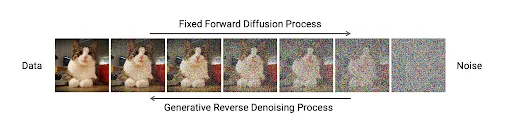

***Diffusion***

Diffusion 모델은 이미지나 오디오와 같은 데이터를 생성하기 위한 확률적 생성 모델입니다. 이 모델은 random gaussian noise를 점진적으로 제거하여 원래의 데이터 형태를 복원하도록 학습됩니다. 최근에는 AI가 생성한 이미지나 동영상이 인터넷에서 많이 보이는데, 이들 대부분이 Diffusion 모델 기반입니다. GAN과 같은 다른 생성 모델에 비해 뛰어난 성능을 보이며, 특히 고품질의 이미지 생성에 강점을 가지고 있습니다.

Diffusion 모델에 대해 좀 더 자세한 설명이 알고 싶다면, 아래 링크를 통해 들어가셔서 게시물을 읽어보시는 것을 추천드립니다!
https://huggingface.co/blog/annotated-diffusion



하지만 일반적인 Diffusion 모델에는 한 가지 단점이 있습니다.
Denoising process가 여러 단계를 거쳐야 하므로 속도가 느리며, 고해상도 이미지를 생성하려면 많은 연산 리소스가 필요합니다. 이를 보완하기 위해 등장한 것이 Latent Diffusion(Stable Diffusion)입니다.

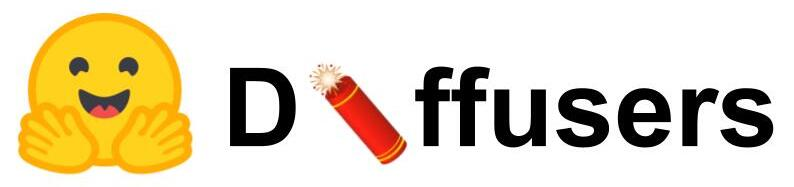

***Diffusers 라이브러리***

Hugging Face의 Diffusers 라이브러리는 누구나 diffusion 모델들을 쉽게 이용할 수 있도록 설계된 라이브러리입니다. 이번 실습에서는 Diffusers 라이브러리를 통해 간단하게 Diffusion 모델로 image를 생성해보고, 기본 Diffusion 파이프라인과 Stable Diffusion 파이프라인에 대해 살펴보도록 하겠습니다!

먼저 기본 Diffusion 파이프라인부터 살펴볼까요?

Diffusion 모델을 실행하려면 여러 과정이 필요하지만, **파이프라인**을 사용하면 몇 줄의 코드만으로 쉽게 이미지를 생성할 수 있습니다!

아래 코드처럼 Diffusers에서 제공하는 Diffusion 파이프라인을 사용하면 이미지를 간단하게 생성할 수 있습니다:

In [ ]:
from diffusers import DDPMPipeline

ddpm = DDPMPipeline.from_pretrained("google/ddpm-celebahq-256").to("cuda")
image = ddpm(num_inference_steps=25).images[0]
image

정말 쉽지 않나요?! 그런데 파이프라인은 어떻게 이렇게 이미지를 생성할 수 있었을까요? 궁금하실테니까 파이프라인 내부에서 어떤 일이 일어나고 있는지 같이 살펴보겠습니다!


In [ ]:
ddpm

사실 위의 파이프라인에는 `UNet2DModel`과 `DDPMScheduler`가 숨어있습니다. 파이프라인은 원하는 output과 동일한 shape의 random noise를 받아 모델을 여러번 timestep만큼 통과시켜 이미지의 noise를 제거합니다. 각 timestep마다,

`UNet2DModel`은 현재 시점의 이미지가 가지고 있는 noise 성분을 예측하고,

`DDPMScheduler`는 UNet이 예측한 noise를 어떻게 활용해서 다음 스텝의 이미지를 업데이트할지를 결정합니다. 다시말해서, scheduler는 UNet이 예측한 noise, 현재 시점, 현재 이미지 이 세 정보를 이용해, 정해진 수식에 따라 다음 스텝의 이미지를 계산합니다.

이 두 요소가 협력하여 점진적으로 noise를 제거하며 이미지를 생성합니다. 그리고 파이프라인은 지정된 step 수 끝까지 도달할 때까지 이 과정을 반복합니다. 마치 사진 보정 전문가와 보조 작가처럼,` UNet2DModel`과 `DDPMScheduler`는 같이 협력해서 그림을 점점 완성해 나가는데, 이 두 가지가 없으면 Diffusion 모델은 그림을 그릴 수 없게 됩니다.


model과 scheduler를 별도로 사용하여 파이프라인을 다시 생성하기 위해 denoising process를 작성해 보겠습니다.

1. 먼저 model과 scheduler를 불러옵니다:

In [ ]:
from diffusers import DDPMScheduler, UNet2DModel

scheduler = DDPMScheduler.from_pretrained("google/ddpm-celebahq-256")
model = UNet2DModel.from_pretrained("google/ddpm-celebahq-256").to("cuda")

2. 그다음 denoising process를 실행할 timestep 수를 설정합니다:

In [4]:
scheduler.set_timesteps(50)

위의 코드처럼 scheduler의 timestep을 설정하면 균등한 간격의 구성 요소를 가진 tensor가 생성됩니다. 여기서는 50개의 균등한 간격을 가진 tensor가 생성되겠죠? 각 요소는 모델이 이미지의 noise를 제거하는 시간 간격에 해당합니다. 나중에 denoising 루프를 만들 때 이 tensor를 반복하여 이미지의 noise를 제거합니다. 아래를 실행해서 tensor를 확인해봅시다:

In [ ]:
scheduler.timesteps

3. output과 같은 shape을 가진 random noise를 생성합니다. Diffusion 모델은 noise에서 시작하여 점진적으로 이미지를 복원합니다. 따라서 먼저 output과 동일한 shape의 random noise를 생성해야 합니다:

In [6]:
import torch

sample_size = model.config.sample_size
noise = torch.randn((1, 3, sample_size, sample_size), device="cuda")

4. 이제 timestep을 반복하는 루프를 작성합니다. 각 timestep에서 `model`은 `UNet2DModel.forward()`를 통해 `noisy residual`을 예측하여 반환합니다. `scheduler`의 `step()` 메서드는 `noisy residual`, `timestep`, 그리고 `input`을 가지고 이전 timestep에서의 이미지를 계산합니다. 이 계산한 output은 denoising 루프의 다음 input으로 업데이트 되며, `timesteps` 배열의 끝에 도달할 때까지 이 과정이 계속 반복됩니다.

In [7]:
input = noise

for t in scheduler.timesteps:
    with torch.no_grad():
        noisy_residual = model(input, t).sample
    previous_noisy_sample = scheduler.step(noisy_residual, t, input).prev_sample
    input = previous_noisy_sample

5. 마지막 단계는 desnoising process가 완료되고 noise가 제거된 output을 이미지로 변환하는 것입니다:

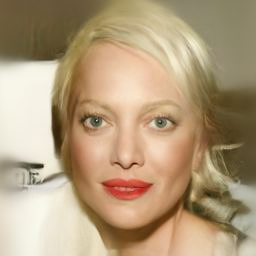

In [8]:
from PIL import Image
import numpy as np

image = (input / 2 + 0.5).clamp(0, 1)
image = image.cpu().permute(0, 2, 3, 1).numpy()[0]
image = Image.fromarray((image * 255).round().astype("uint8"))
image

어때요 생각보다 간단하지 않나요?! 지금까지 한 과정을 다시 살펴보자면,
1. 먼저 필요한 구성요소들을 초기화하고 timestep수를 설정하여 timestep 배열을 생성합니다.
2. 그리고 denoising 루프에서 timestep 배열이 사용되는데, 이 배열의 각 요소에 대해 모델은 denoise된 이미지를 예측합니다.
3. denoising 루프은 각 timestep에서 noisy residual을 출력하고 scheduler는 이를 사용하여 이전 timestep으로부터 denoise된 이미지를 예측합니다. 예측한 결과는 denoising 루프의 input이 되어 timestep 배열의 끝에 도달할 때까지 이 루프가 반복됩니다.

이번에는 앞서 사용한 pretrained ddpm 모델 `google/ddpm-celebahq-256 `를 제외한 다른 ddpm 모델을 사용해 이미지를 생성해봅시다!

HuggingFace 홈페이지에 접속해서 직접 찾아보거나, 아래 링크에 접속해 모델을 찾아서 코드를 완성해 볼까요?
https://huggingface.co/models?search=ddpm

In [ ]:
from diffusers import DDPMPipeline

ddpm = ############TODO#############
image = ###########TODO##############
image

## 4-2 Stable Diffusion

일반적으로 Diffusion 모델은 머신러닝 시스템의 한 종류로, random gaussian noise를 점진적으로 제거하여 원하는 샘플을 생성하도록 학습됩니다.

Diffusion 모델은 GAN과 같은 다른 생성 모델들에 비해 이미지 생성 분야에서 뛰어난 성능을 보이는데, 한 가지 단점이 있습니다. Denoising process가 여러 단계를 거쳐야 하므로 속도가 느리다는 점입니다. 또한, 대부분의 Diffusion 모델은 pixel space에서 작동하기 때문에 고해상도 이미지를 생성하려면 많은 메모리와 연산 리소스가 필요합니다. 따라서 이러한 모델을 Training하고 Inference에 활용하는 것이 어렵습니다.

이를 보완하기 위해 나온 것이 Latent Diffusion 모델입니다. Latent Diffusion 모델은 denoising process를 저차원 latent space에서 수행하여 연산 및 메모리 부담을 줄입니다.
즉, pixel space에서 직접 작업하는 대신, 이미지를 압축하여 더 작은 latent space에서 처리하는 방식입니다! 이 덕분에 전체 이미지(pixel space)가 아니라 저차원 표현에서 작업하므로 훨씬 더 적은 리소스를 필요로 합니다. 그리고 pixel space보다 훨씬 작은 latent space에서 연산하므로 denoising process가 더 빠릅니다.

저희가 오늘 살펴볼 Stable Diffusion은 text-to-image Latent Diffusion 모델에 해당하는데요, diffusers에서는 마찬가지로 Stable Diffusion에 대한 파이프라인도 제공하고 있습니다. text로 image를 생성하는데 5줄도 필요하지 않을 정도로 간단합니다!

아래 코드에서 text prompt를 작성해서 새로운 이미지를 한 번 생성해보세요!

In [ ]:
from diffusers import DiffusionPipeline

pipe = DiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5")
pipe.to("cuda")
prompt = ################TODO###############
image = pipe(prompt).images[0]
image

그런데 위의 코드는 실행될 때마다 다른 이미지를 생성할 겁니다.

매번 똑같은 이미지를 생성하도록 하고 싶으면, random seed를 추가하면됩니다.
아래 코드처럼 seed를 추가하면 이미지가 고정적으로 생성되는 것을 볼 수 있습니다! seed 번호를 바꾸면 그제서야 다른 이미지가 생성되는 것을 확인할 수 있을 거에요

In [ ]:
import torch

generator = torch.Generator("cuda").manual_seed(1016)
image = pipe(prompt, guidance_scale=7.5, generator=generator).images[0]
image

파이프라인이 어떻게 이렇게 할 수 있는지, 이번에도 파이프라인 내부에서 어떤 일이 일어나고 있는지 살펴보겠습니다.

그 전에, Stable Diffusion에서는 어떤 요소들을 필요로 하는지부터 알아볼까요?


---



In [ ]:
pipe

Stable Diffusion은 크게 Variational Auto Encoder(VAE), UNet, Text Encoder로 구성됩니다. 아래는 Stable Diffusion의 구성요소와 Inference 과정을 그림으로 나타낸 것입니다.

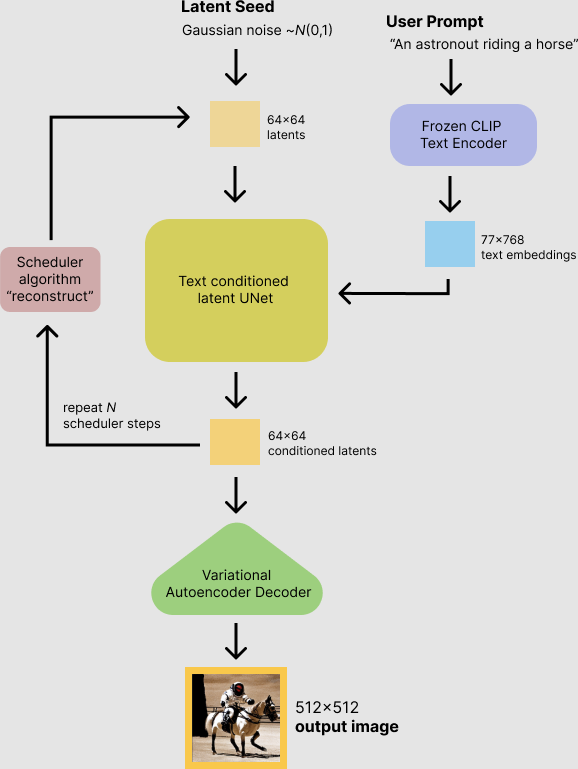

#### 1) Variational Auto Encoder (VAE)

VAE는 **Encoder**와 **Decoder**로 구성됩니다.

*   Encoder : 이미지를 저차원 **latent representation**으로 변환.
*   Decoder : latent representation을 다시 **픽셀 공간**으로 변환하여 실제 이미지를 생성.

Latent Diffusion에서는 Training 할 때 Encoder를 사용하여 이미지의 latent representation을 얻고, 이를 Diffusion process에 적용합니다.
그리고 Inference 시에는 noise가 제거된 latent representation을 Decoder를 통해 다시 이미지로 변환합니다. 즉, Inference할 때는 Decoder만 필요합니다.

---



#### 2) UNet

UNet은 기본적으로 **Encoder**와 **Decoder**로 이루어진 nueral network입니다.


*   Encoder : Input 이미지를 **low resolution representation**으로 압축.
*   Decoder : low resolution representation을 원래의 **high resolution**으로 변환.

그러나 Stable Diffusion에서의 UNet은 단순히 이미지를 변환하는 것이 아니라,
**noise를 제거**하는 데 초점을 맞춘 구조를 가지고 있습니다.

특히 Stable Diffusion의 UNet은 일반적인 UNet에 Cross-Attention 레이어을 추가한 구조를 가지고 있는데, Stable Diffusion은 다음과 같은 특징이 있습니다.


*   **ResNet 블록**을 사용하여 신경망을 구성.
*   **Cross-Attention 레이어**를 추가하여 텍스트 정보와 결합.
*   **skip connection**을 사용하여 UNet의 Encoder에서 Decoder로 중요한 정보를 직접 전달.

즉, UNet은 "**주어진 noisy한 이미지에서 noise를 얼마나 제거해야 하는지**" 예측하는 역할을 합니다.

---



#### 3) Text Encoder

Text Encoder는 "A painting of pikachu in van gogh style" 같은 Input prompt를 neural network가 이해할 수 있도록 **embedding vector**로 변환하는 역할을 합니다.
Stable Diffusion에서는 Text Encoder로 `CLIPTextModel`을 사용하며, 따로 훈련시키지 않고 이미 pretrained된 모델을 그대로 활용합니다.

Text Encoder가 생성한 text embedding은 UNet에 전달되어 이미지 생성 과정에 영향을 줍니다. 즉, "반고흐가 그린 피카츄" 이미지가 생성될 수 있도록 해당 텍스트 정보가 반영됩니다.


---



계속 말씀드렸듯이, Latent Diffusion은 픽셀 공간이 아닌 **저차원의 latent space** 에서 연산하기 때문에 빠르고 메모리 효율적입니다. 일반적으로, Stable Diffusion에서 사용하는 VAE는 8배의 down-scaling을 수행합니다. 즉, 원본 이미지 크기가 **(3, 512, 512)**라면, VAE를 통과한 latent space에서는 **(4, 64, 64)** 크기의 데이터로 변환됩니다.
이는 64배(8×8)의 공간 절약 효과를 의미하며, 이 덕분에 지금 저희도 Colab의 16GB GPU에서 512×512 해상도의 이미지를 빠르게 생성할 수 있는 것입니다!

이제 Stable Diffusion 파이프라인에 필요한 구성요소들이 무엇인지 알았으니, 파이프라인 내부에서 어떤 일이 있는지 또 알아볼까요?

1. 먼저 from_pretrained() 메서드를 사용해 모든 구성요소를 불러옵니다. 저희는 pretrained된 모델로 `runwayml/stable-diffusion-v1-5`를 사용하도록 하겠습니다. 이 Stable Diffusion 모델의 각 구성요소들은 별도의 하위 폴더에 저장되어 있습니다:

In [11]:
from PIL import Image
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler

vae = AutoencoderKL.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="vae")
tokenizer = CLIPTokenizer.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="text_encoder")
unet = UNet2DConditionModel.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="unet")

불러온 모델들을 GPU로 옮겨볼게요:

In [ ]:
torch_device = "cuda"
vae.to(torch_device)
text_encoder.to(torch_device)
unet.to(torch_device)

In [29]:
prompt = ["a painting of pikachu in van gogh style"]
height = 512  # Stable Diffusion의 기본 높이
width = 512  # Stable Diffusion의 기본 너비
num_inference_steps = 50  # 노이즈 제거 스텝 수
guidance_scale = 7.5  # classifier-free guidance를 위한 scale
generator = torch.Generator(device=torch_device).manual_seed(1016)  # 초기 잠재 노이즈를 생성하는 seed generator
batch_size = len(prompt)

여기서 `num_inference_steps` 변수는 Stable diffusion 모델을 Inference할 때 UNet에서 noise를 제거하는 step의 수입니다.

그리고 `guidance_scale` 매개변수는 이미지를 생성할 때 프롬프트에 얼마나 많은 가중치를 부여할지 결정합니다.


In [ ]:
###################TODO#####################
## 아래 질문에 대해 자유롭게 답변해주세요!##
############################################

# Q1. num_inference_steps를 늘리거나 줄일수록 어떤 경향을 보이나요?
# A1.

# Q2. guidance_scale을 늘리거나 줄일수록 어떤 경향을 보이나요?
# A2.

2. 다음으로, embedding을 생성하기 위해 text prompt를 tokenize합니다. 이 text는 UNet모델에서 condition으로 사용되는데, input text와 유사한 방향으로 diffusion process가 일어나도록 조정하는 데 사용됩니다.

text를 tokenize하고 embedding을 생성합니다:

In [30]:
text_input = tokenizer(
    prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt"
)

with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

참고로, Stable Diffusion은 **unconditional embedding**을 함께 사용하여 더 다양한 이미지 생성을 유도합니다:

In [31]:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")
uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]

conditional embedding과 unconditional embedding을 batch로 연결해줍니다:

In [32]:
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

3. 다음으로는 초기 random noise를 생성합니다. Diffusion 모델은 완전히 랜덤한 노이즈에서 시작하여 점진적으로 이미지를 생성합니다.

In [33]:
latents = torch.randn(
    (batch_size, unet.config.in_channels, height // 8, width // 8),
    generator=generator,
    device=torch_device
)

이때, Stable Diffusion의 VAE는 3개의 downsampling layer를 가지고 있기 때문에 latent space에서의 크기는 원본 크기의 1/8이 됩니다.

4. 그 다음, denoising 작업을 수행하여 이미지를 생성합니다.

이전의 *4-1 Diffusion*에서 했던 것과 유사하게 denoising 루프를 통해 random noise를 이미지로 변환합니다. 이때, text prompt를 반영하여 이미지가 생성됩니다. denoising 루프를 다시 복습하자면,

1)   denoise proccess에 사용할 scheduler의 timesteps를 설정하고,

2)   각 timestep에서 UNet 모델을 호출하여 noise residual을 예측하고 scheduler에 전달하여 이전 noise 샘플을 계산하는데,

3)   이것을 timestep을 따라 반복합니다:


In [ ]:
from tqdm.auto import tqdm

scheduler.set_timesteps(num_inference_steps)

for t in tqdm(scheduler.timesteps):
    latent_model_input = torch.cat([latents] * 2)
    latent_model_input = scheduler.scale_model_input(latent_model_input, timestep=t)

    # noise residual 예측
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # guidance 수행
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # 이전 노이즈 샘플을 계산 x_t -> x_t-1
    # 4-1 Diffusion 과 똑같이 scheduler가 세 가지를 input으로 받아 latent를 update
    latents = ##########TODO##########

5. 마지막으로, VAE의 decoder를 이용하여 latent representation을 이미지로 디코딩하고 sample과 함께 디코딩된 output을 얻습니다:

In [44]:
# VAE Decoder로 변환하기 전에 스케일 조정
latents = 1 / 0.18215 * latents

In [45]:
# VAE Decoder를 통해 최종 이미지 생성
with torch.no_grad():
    image = vae.decode(latents).sample

이미지를 PIL.Image로 변환하면 생성된 이미지를 확인할 수 있습니다!

In [ ]:
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]



---



지금까지 Diffusers 라이브러리를 통해 Diffusion과 Stable Diffusion을 활용한 이미지 생성 과정을 직접 실습해 보았습니다!
이번 실습을 통해 Inference 과정에서 Diffusion 모델의 내부 동작을 이해하고, 텍스트 기반 이미지 생성을 경험해 보셨는데,

이번 실습에서 다루지 못했던 Diffusion 모델의 Training 과정이 궁금하신 분들은
https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/training_example.ipynb

해당 실습을 진행해보시는 것을 추천드립니다!!

## 이제 정말 끝입니다! 방학 동안 열심히 D2D 과제를 해오신 여러분, 정말 수고 많으셨습니다 😃


